In [1]:
import pandas as pd
from datetime import date
import cbpro
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset

C:\Users\Artem\AppData\Local\Temp\ipykernel_19760\2209050979.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
with open('CoinBaseAPIKey.key', 'r') as f:
    contents = f.readlines()
cb_key = contents[0].split(':')[-1].strip()
cb_secret = contents[1].split(':')[-1].strip()

In [3]:
#Download data
public_client = cbpro.PublicClient()
slots = [('2023-01-01', '2023-06-01'), ('2022-07-01', '2022-12-31'), ('2022-01-01', '2022-06-30'), ('2023-06-02', '2023-12-01')]
BTC = Asset('BTC')
ETH = Asset('ETH')
USDT = Asset('USDT')

for slot in slots:
    BTC_USD = public_client.get_product_historic_rates('BTC-USD', slot[0], slot[1], 86400)
    ETH_USD = public_client.get_product_historic_rates('ETH-USD', slot[0], slot[1], 86400)
    USDT_USD = public_client.get_product_historic_rates('USDT-USD', slot[0], slot[1], 86400)
    btc_data= pd.DataFrame(BTC_USD)
    btc_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    btc_data['date_time']= btc_data['date_time'].apply(lambda x: date.fromtimestamp(x))
    BTC.update_history(btc_data)

    ETH_data= pd.DataFrame(ETH_USD)
    ETH_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    ETH_data['date_time']= ETH_data['date_time'].apply(lambda x: date.fromtimestamp(x))
    ETH.update_history(ETH_data)

    USDT_data= pd.DataFrame(USDT_USD)
    USDT_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    USDT_data['date_time']= USDT_data['date_time'].apply(lambda x: date.fromtimestamp(x))
    USDT.update_history(USDT_data)

In [4]:
my_portfolio = Portfolio()
my_portfolio.do_transaction(ticker='BTC', qty=1, transaction_date=date.fromisoformat('2023-11-01'))
my_portfolio.do_transaction(ticker='USDT', qty=40000, transaction_date=date.fromisoformat('2023-11-01'))
my_portfolio.do_transaction(ticker='BTC', qty=-0.5, transaction_date=date.fromisoformat('2023-11-15'))
my_portfolio.do_transaction(ticker='USDT', qty=-2000, transaction_date=date.fromisoformat('2023-11-15'))

In [6]:
my_portfolio.get_value(date.fromisoformat('2023-11-12'))

18    76484.87
Name: value, dtype: float64

In [7]:
my_portfolio.get_positions(date.fromisoformat('2023-11-12'))

,ticker,position_size,position_value
0,BTC,1,36475.67
1,USDT,40000,40009.2


In [ ]:
# Plot data we got
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(BTC.history['date_time'], BTC.history['close'], color = 'black', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)

In [22]:
# Set up configuration objects and params
prediction_days = 15
scaler  = MinMaxScaler(feature_range=(0,1))
len_train = int(0.7*len(BTC.history))
len_test = len(BTC.history) - len_train

In [25]:
#Generate training data
x_train = []
y_train = []
scaled_data = scaler.fit_transform(np.array(BTC.history['close'].values).reshape(-1,1) )
for x in range(prediction_days, len_train):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
x_train, y_train = (np.array(x_train), np.array(y_train))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


In [27]:
# Create, compile, train the model
model = Sequential()
model.add(LSTM(units = 50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
optimizer = Adam(learning_rate=0.001, name='Adam')

model.compile(optimizer = optimizer, loss = 'mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=8)

In [ ]:
input_data = BTC.history['close'].iloc[(len_train-prediction_days):]
prediction_prices = []
# Given the new data go one time point after another and make predictions 
for x in range(prediction_days, len(input_data)):
    model_input = scaler.fit_transform(np.array(input_data[x-prediction_days:x].values).reshape(-1,1) )
    model_input = np.array(model_input).reshape(1,prediction_days,1)
    prediction = model.predict(model_input,verbose = 0)
    prediction = scaler.inverse_transform(prediction)[0][0]
    print(f'Today:{input_data.iloc[x]}, predicted tomorrow: {prediction}')
    prediction_prices.append(prediction)

In [90]:
# Make data frame for final plotting
pred_df = pd.DataFrame(prediction_prices)
pred_df.columns = ['BTC_predicted']
plot_test = pd.concat([BTC.history.iloc[len_train:].reset_index(), pred_df[['BTC_predicted']].reset_index()], axis=1)

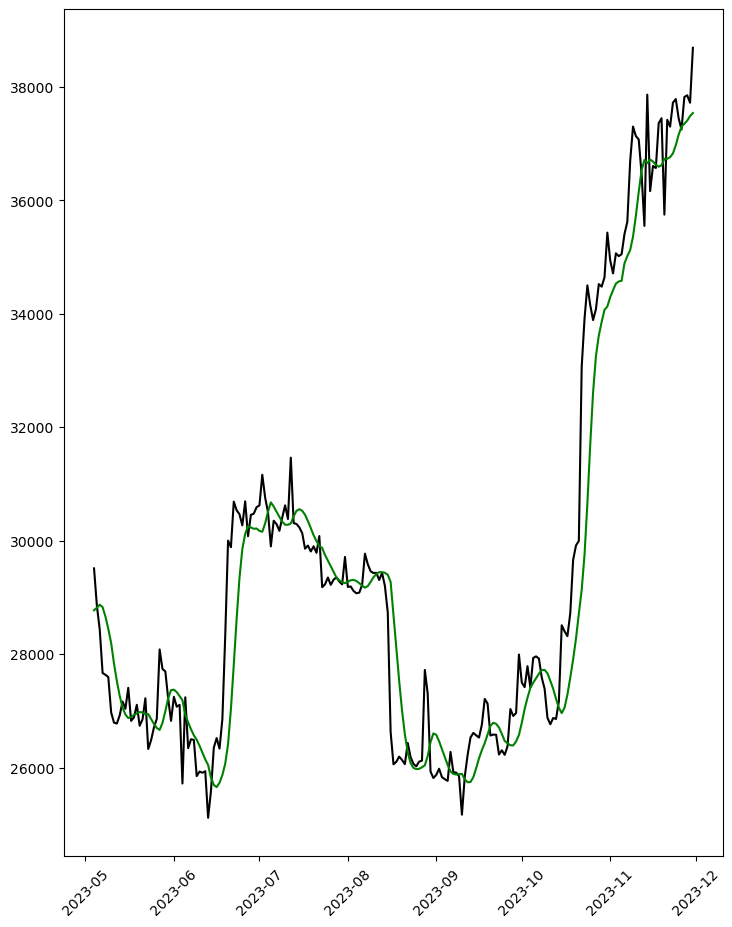

In [91]:
# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(plot_test['date_time'], plot_test['close'], color = 'black', label = 'Historic price')
ax.plot(plot_test['date_time'], plot_test['BTC_predicted'], color = 'green', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)